In [1]:
import numpy as np
import pandas as pd
import umap
import altair as alt 
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score

2022-10-24 06:12:03.989824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-24 06:12:04.199593: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-24 06:12:04.203835: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-24 06:12:04.203851: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

#### Prepare Vessel Data

Import preprocessed vessel data from "UMAP_on_Vessel_Data" notebook. This dataset includes additional UMAP embedding features which we will use to do clustering. 

In [2]:
df_raw = pd.read_csv('data/generated_data/vessel_data_with_umap_embeddings.csv')
# df_raw.info()

Since we've found the optmal UMAP embedding ('comp1' and 'comp2') features,we will drop others unnecessary columns from the dataset.

In [3]:
df_vessel = df_raw.drop(['n5_comp1','n5_comp2', 'n15_comp1', 'n15_comp2', 
            'n50_comp1', 'n50_comp2','n100_comp1', 'n100_comp2',
            'n350_comp1','n350_comp2'], axis = 1)

df_vessel['is_holiday'] = df_vessel['is_holiday'].astype(object)

x = df_vessel.drop(['dwell_in_hr', 'dwell_class'], axis=1)
y = df_vessel['dwell_class']
x.head(3)

,avg_dwell_at_target_terminal,num_of_vessel_at_target_terminal,num_of_vessel_in_port,weekday,hour_of_day,is_holiday,vessel_width,vessel_length,vessel_dwt,target_terminal,vessel_operator,comp1,comp2
0,25.5,1.0,50.0,1,10,False,30.0,210.0,34677.0,PierT,MAERSK,-16.663086,20.422855
1,46.4,2.0,53.0,6,10,False,30.0,210.0,34677.0,PierT,MAERSK,-16.044365,20.667452
2,14.0,0.0,57.0,2,0,False,32.0,262.0,30825.0,PierA,MATSON,-18.015656,23.685846


#### Apply DBSCAN over UMAP output

Estimate optimal epsilon parameter by k-distances plot.

Use n_neighbors = 2*{dim(dataset)} - 1 referred by rules of thumb from the original DBSCAN authors’ papers (Sander et al., 1998) and (Schubert et al., 2017).

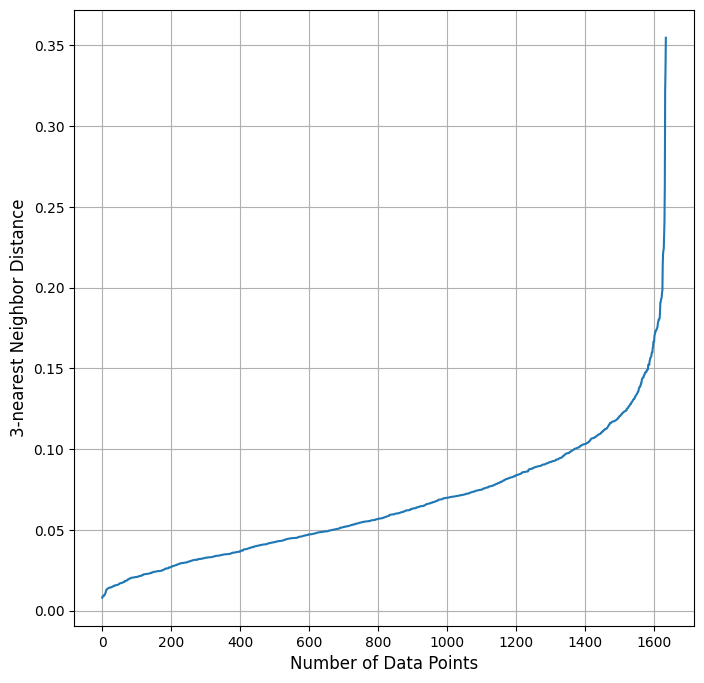

In [4]:
from sklearn.neighbors import NearestNeighbors

def make_kdist_plot(data=None, n=None):
    # get distance
    neigh = NearestNeighbors(n_neighbors=n)
    nbrs = neigh.fit(data)

    distances, indices = nbrs.kneighbors(data)                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, n-1]
    df_distances = pd.DataFrame(distances, columns=['distances'])
    df_distances = df_distances.reset_index()

    # plot k-distance 
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Number of Data Points', fontsize=12)
    plt.ylabel('{}-nearest Neighbor Distance'.format(n), fontsize=12)
    plt.grid()
    plt.show()
    plt.close()

    return df_distances

 # use n_neighbors = 2*{dim(dataset)} - 1 
n = 2 * df_vessel[['comp1','comp2']].shape[-1] - 1

df_distances = make_kdist_plot(df_vessel[['comp1','comp2']], n=n)

In [5]:
epsilon = 0.15 # default = 0.5
min_samples = 100 # default = 5

dbscan = DBSCAN(eps=0.15, min_samples=22).fit(df_vessel[['comp1','comp2']])

cluster_labels= dbscan.labels_

no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

print(f'Estimated no. of clusters: {no_clusters}')
print(f'Estimated no. of noise points: {no_noise}')

df_vessel['cluster_labels'] = pd.Series(cluster_labels)

alt.Chart(data=df_vessel).mark_circle(size=60).encode(
    x=alt.X('comp1:Q', scale=alt.Scale(domain=[-19, -11])),
    y=alt.Y('comp2:Q', scale=alt.Scale(domain=[18, 25])),
    color=alt.Color('cluster_labels:N', scale=alt.Scale(scheme='dark2')),
    tooltip=[
        'target_terminal:N', 
        'avg_dwell_at_target_terminal:Q', 
        'num_of_vessel_at_target_terminal:Q', 
        'weekday:O', 
        'hour_of_day:O', 
        'is_holiday:N',
        'vessel_operator:N',
        'dwell_in_hr:Q',
        'cluster_labels:O'
    ]
).properties(
    width=600,
    height=600
).interactive()

Estimated no. of clusters: 10
Estimated no. of noise points: 981


alt.Chart(...)

In [6]:
silhouette_score(df_vessel[['comp1', 'comp2']],df_vessel['cluster_labels'])

-0.22392739124659614

After applying DBSCAN with epsilon = 0.15 and a combination of different min_samples, we found that epsilon = 0.15 is not good for finding meaningful clsuters. 

This is because more than half of the data points were identified as outliers and the Silhouette score is -0.22.

The reason is that instead of computing n_neighbors using the number of dimensions (11) in the original dataset, we used the number of umap embeddings, which is 2.

Let's recalculate the distance with n_neighbors = 2*11 -1, which is 21 and use it as the DBSCAN's epsilon value.

In [7]:
# excludes the umap embeddings
n = 2 * x.iloc[:,0:11].shape[-1] - 1
n

21

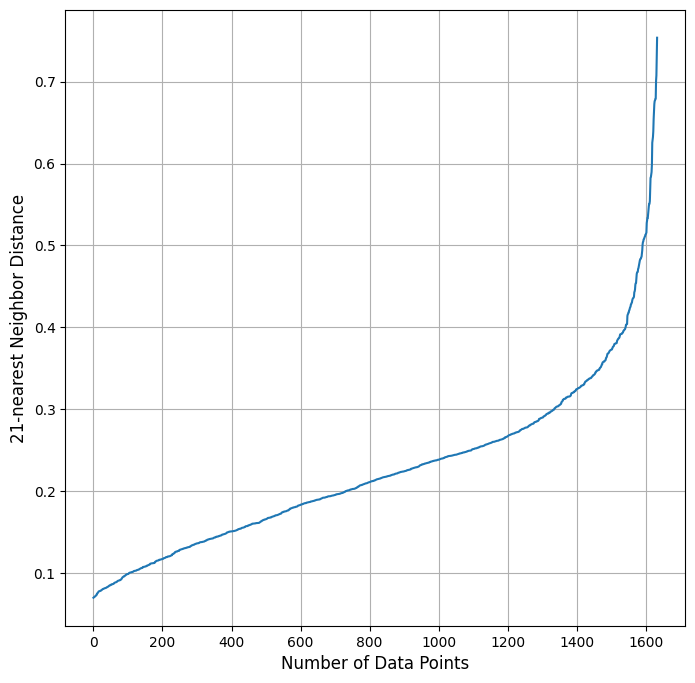

In [8]:
df_distances = make_kdist_plot(df_vessel[['comp1','comp2']], n=n)

Apply DBSCAN with the reasonable paramaters evaluated based on domain knowledge and some rules of thumb from the original DBSCAN authors’ papers (Sander et al., 1998) and (Schubert et al., 2017) to see the clusters.

In [9]:
epsilon = 0.5 # default = 0.5
min_samples = 100 # default = 5

dbscan = DBSCAN(eps=0.5, min_samples=min_samples).fit(df_vessel[['comp1','comp2']])

In [10]:
cluster_labels= dbscan.labels_

no_clusters = len(np.unique(cluster_labels) )
no_noise = np.sum(np.array(cluster_labels) == -1, axis=0)

print(f'Estimated no. of clusters: {no_clusters}')
print(f'Estimated no. of noise points: {no_noise}')

Estimated no. of clusters: 6
Estimated no. of noise points: 179


In [11]:
df_vessel['cluster_labels'] = pd.Series(cluster_labels)
df_vessel.head(1)

,avg_dwell_at_target_terminal,num_of_vessel_at_target_terminal,num_of_vessel_in_port,weekday,hour_of_day,is_holiday,vessel_width,vessel_length,vessel_dwt,target_terminal,vessel_operator,dwell_in_hr,dwell_class,comp1,comp2,cluster_labels
0,25.5,1.0,50.0,1,10,False,30.0,210.0,34677.0,PierT,MAERSK,75.7,72-96,-16.663086,20.422855,3


In [12]:
alt.Chart(data=df_vessel).mark_circle(size=60).encode(
    x=alt.X('comp1:Q', scale=alt.Scale(domain=[-19, -11])),
    y=alt.Y('comp2:Q', scale=alt.Scale(domain=[18, 25])),
    color=alt.Color('cluster_labels:N', scale=alt.Scale(scheme='dark2')),
    tooltip=[
        'target_terminal:N', 
        'avg_dwell_at_target_terminal:Q', 
        'num_of_vessel_at_target_terminal:Q', 
        'weekday:O', 
        'hour_of_day:O', 
        'is_holiday:N',
        'vessel_operator:N',
        'dwell_in_hr:Q',
        'cluster_labels:O'
    ]
).properties(
    width=600,
    height=600
).interactive()

alt.Chart(...)

In [13]:
# test the dbscan performance on umap embeddings
dbscan_sil_score = silhouette_score(df_vessel[['comp1', 'comp2']],df_vessel['cluster_labels'])
dbscan_sil_score

0.4989936796417393

Findings:
- Overall, DBSCAN with epsilon = 0.5, min_samples = 100 does pretty well on identifying clusters based on terminal, although it missed Pier G because of its small number of records.  
- On the other hand, while the identified outliners look make sense in this plot, from dwell time perspective we may not agree they are outliners.
- the "optimal" epsilon value 0.15 estimated from the k-distance plot doesn't perform well. Instead,after playing around several epsilons and MinPts values based our domain knowledge and research, we found MinPts of 100 and epsilon of 0.5 is the reasonable paramters in our case.

potential improvements:
- need other cluster algorithms to double-check the clusters.

#### Apply KMeans over UMAP output

Find the optimal number of clusters using Elbow method.

In [14]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer,SilhouetteVisualizer
import matplotlib.pyplot as plt
%matplotlib inline

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


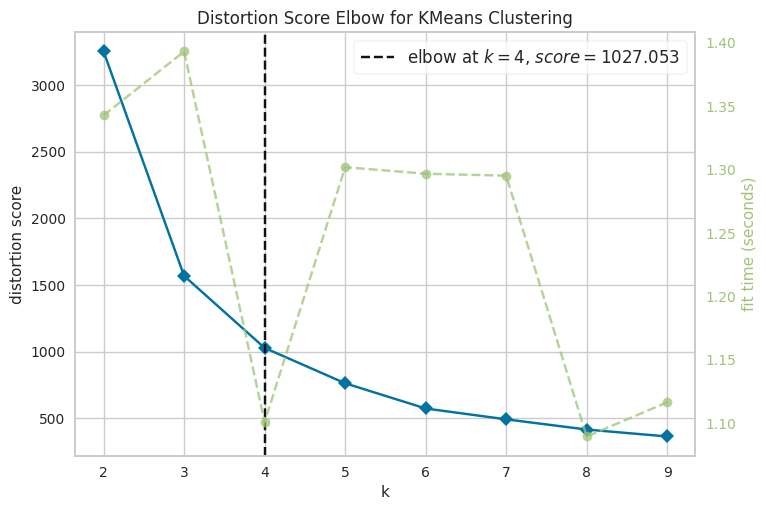

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [15]:
km = KMeans( init='k-means++', n_init=10, max_iter=100, random_state=42)
visualizer = KElbowVisualizer(km, k=(2,10))
 
visualizer.fit(df_vessel[['comp1', 'comp2']])      
visualizer.show()

As we can see, the optimal number of clusters for KMeans is 4.

To make sure we select the most optimal number of clusters, let's also plot clusters with Silhouette scores as the second criteria.

Sihouette plot for n_clusters = 2 to n_clusters = 7


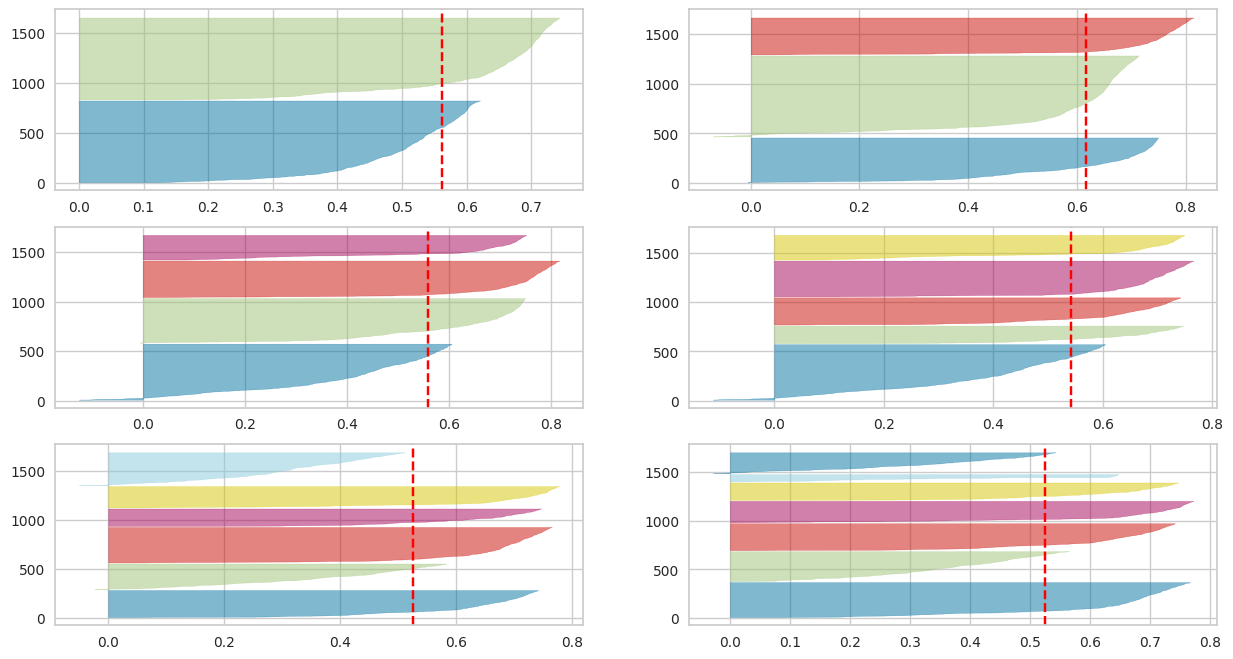

In [16]:
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_vessel[['comp1', 'comp2']]) 
print('Sihouette plot for n_clusters = 2 to n_clusters = 7')

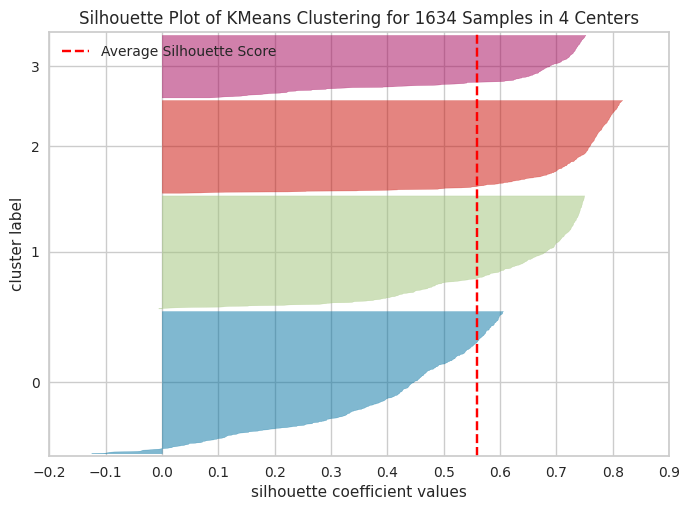

<AxesSubplot:title={'center':'Silhouette Plot of KMeans Clustering for 1634 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [17]:
# get the plot for n_cludters = 4
km = KMeans(n_clusters=4, init='k-means++', n_init=10, max_iter=100, random_state=42)

visualizer = SilhouetteVisualizer(km, colors='yellowbrick')
visualizer.fit(df_vessel[['comp1', 'comp2']]) 
visualizer.show()


The sihouette score plot gives us several options. Overall, we consider n_clusters = 4 to be the optimal one.

We have the highest sihouette score when n_clusters = 3. However, the thicknesses of these clusters are not uniform (thick green clusters in the middle), suggesting that 3 clusters are suboptimal.

n_clusters = 4 or 5 looks better. This is because, none of them have clusters below the average Sihouette score, and the thickness of the clusters is relatively uniform. The Sihouette score for 4 clusters is only slightly higher than that for 5 clusters.


Let's project the clusters on the UMAP.

In [18]:
# make a func to plot kmean clusters on umap output with defined # of clusters
def plot_2d_kmeans_cluster(data, n_clusters, 
                    x_label='umap_comp1', 
                    y_label='umap_comp2',
                    title = 'UMAP projection on vessel dataset with clusters='):
  # train a hierarchial clustering model wit optial num of clusters 
  km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=100, random_state=42)
  y_predicted = km.fit_predict(data)

  # visulizae clusters
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(111)
  # colors = ['blue','orange','green','purple','yellow','red']
  colors = ['#ebac23','#ff9287','#00a76c','#008cf9','#d163e6','#bdbdbd']
  color_to_use = colors[:n_clusters]
  cluster_to_use = range(n_clusters)
  for i,j in zip(cluster_to_use,color_to_use):
    ax.scatter(data[y_predicted == i, 0], data[y_predicted == i, 1], 
              s = 40 , color = j, label = "Cluster " + str(i))
  ax.set_title(title + '{}'.format(n_clusters))
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

  ax.legend()
  plt.show()
  
  return y_predicted

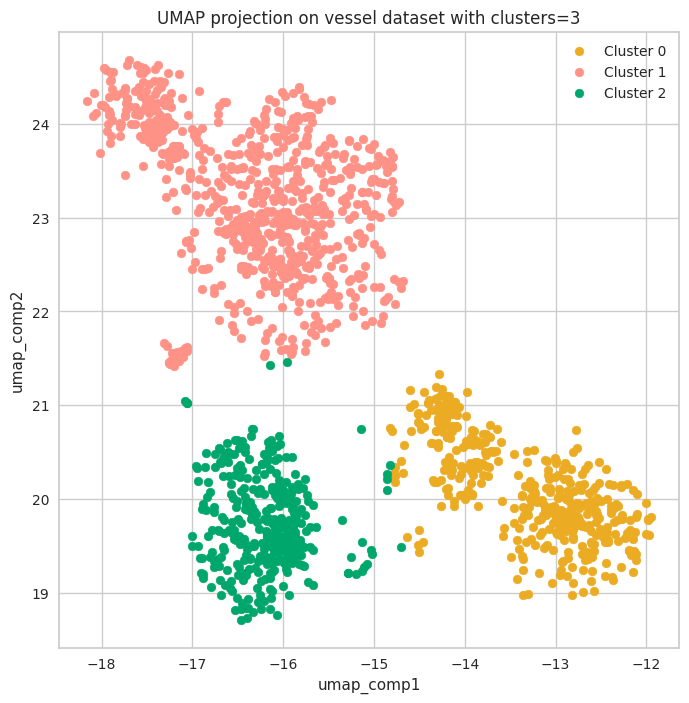

In [19]:
y_predicted = plot_2d_kmeans_cluster(df_vessel[['comp1', 'comp2']].values, 3)

In [20]:
# test the dbscan performance on umap embeddings
silhouette_score(df_vessel[['comp1','comp2']],y_predicted)

0.6173471633885439

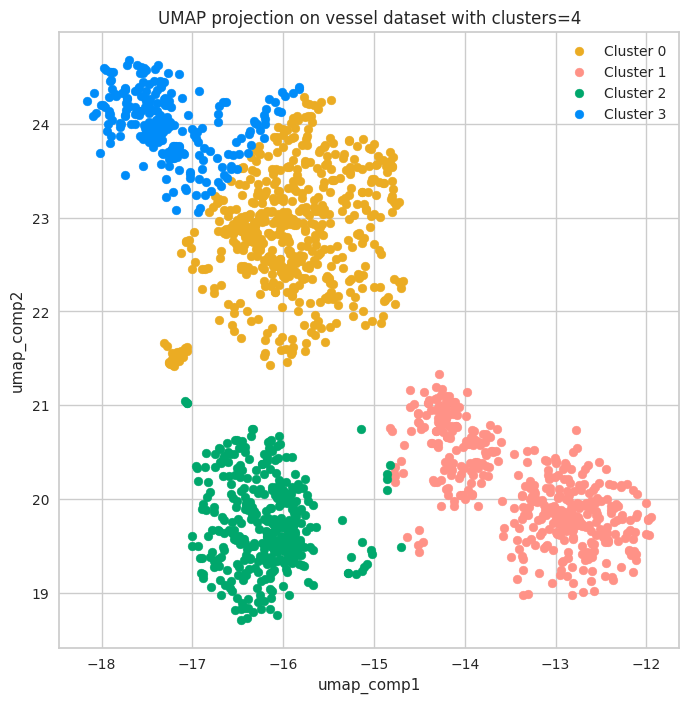

In [21]:
y_predicted = plot_2d_kmeans_cluster(df_vessel[['comp1', 'comp2']].values, 4)

In [22]:
# test the dbscan performance on umap embeddings
silhouette_score(df_vessel[['comp1','comp2']],y_predicted)

0.5590356810821933

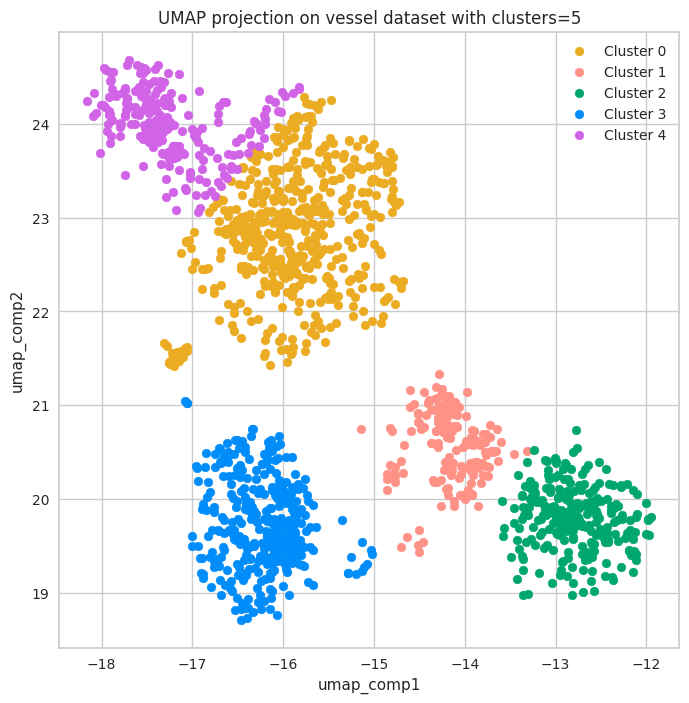

In [23]:
y_predicted = plot_2d_kmeans_cluster(df_vessel[['comp1', 'comp2']].values, 5)

In [24]:
# test the dbscan performance on umap embeddings
silhouette_score(df_vessel[['comp1','comp2']],y_predicted)

0.5429730925645208

Findings:
- The elbow plot showed that the optimal number of clusters is 4.
- The Sihouette score plot showed that 4 and 5 should be the optimal number of clusters.
- Kmeans clustering did a good job of identifying target_termimal based clusters. With this, we think 5 should be the optimal number of clusters, and we found that KMeans does a good job of grouping clusters with different target_termimals, although one target_termimal is missed due to the low number of vessels on the nerminal.

#### Apply Agglomerative over UMAP output

In [25]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [26]:
# helper functions to draw dendrogram and plot the clusters
def plot_truncated_dendrogram(data, p):
  # use dendrogram to find the optimal number of clusters
  plt.figure(figsize=(8,6))
  
  Z1 = linkage(data, 'ward')
  R = dendrogram(Z1, 
                truncate_mode = 'lastp', 
                p = p, 
                show_leaf_counts = False,
                show_contracted=True, # get a distribution impression in truncated branches
            )
  plt.title('Hierarchical Clustering Dendrogram (truncated)', fontsize=14)
  plt.xlabel('Vessels', fontsize=12)
  plt.ylabel('Distance', fontsize=12)
  plt.show()

# helper functions to draw dendrogram and plot the clusters
def plot_full_dendrogram(data):
  # use dendrogram to find the optimal number of clusters
  plt.figure(figsize=(8,4))
  R = dendrogram(linkage(data, method = 'ward'),
                 show_leaf_counts = False,
                 )
  plt.title('Hierarchical Clustering Dendrogram', fontsize=14)
  plt.xlabel('Vessels', fontsize=12)
  plt.ylabel('Distance', fontsize=12)
  plt.show()

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


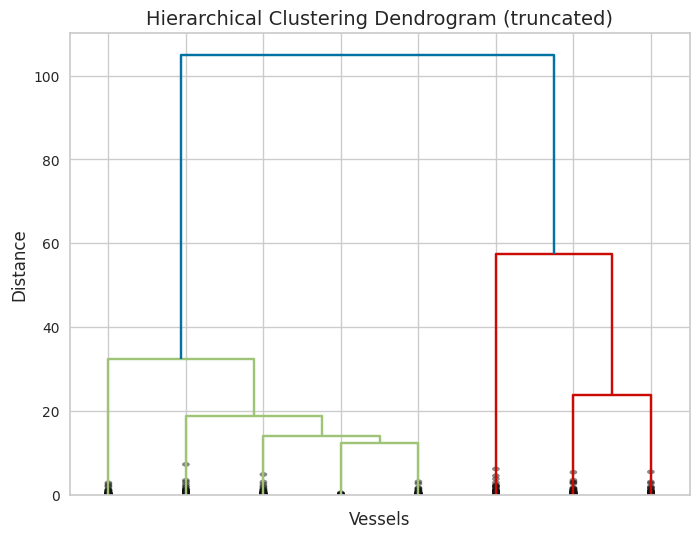

In [27]:
# plot the dendrogram with only the last 8 clusters
plot_truncated_dendrogram(df_vessel[['comp1', 'comp2']], 8)

In [28]:
def plot_2d_agg_cluster(data, n_clusters, 
                    x_label='umap_comp1', 
                    y_label='umap_comp2',
                    title = 'UMAP projection on vessel dataset with clusters='):
  # train a hierarchial clustering model wit optial num of clusters 
  hc = AgglomerativeClustering(n_clusters = n_clusters, linkage = 'ward')
  y_hc = hc.fit_predict(data)

  # visulizae clusters
  fig = plt.figure(figsize = (8,8))
  ax = fig.add_subplot(111)
  # colors = ['blue','orange','green','purple','yellow','red']
  colors = ['#ebac23','#ff9287','#00a76c','#008cf9','#d163e6','#bdbdbd']
  color_to_use = colors[:n_clusters]
  cluster_to_use = range(n_clusters)
  for i,j in zip(cluster_to_use,color_to_use):
    ax.scatter(data[y_hc == i, 0], data[y_hc == i, 1], 
              s = 40 , color = j, label = "Cluster " + str(i))
  ax.set_title(title+'{}'.format(n_clusters)) 
  ax.set_xlabel(x_label)
  ax.set_ylabel(y_label)

  ax.legend()
  plt.show()
  
  return y_hc

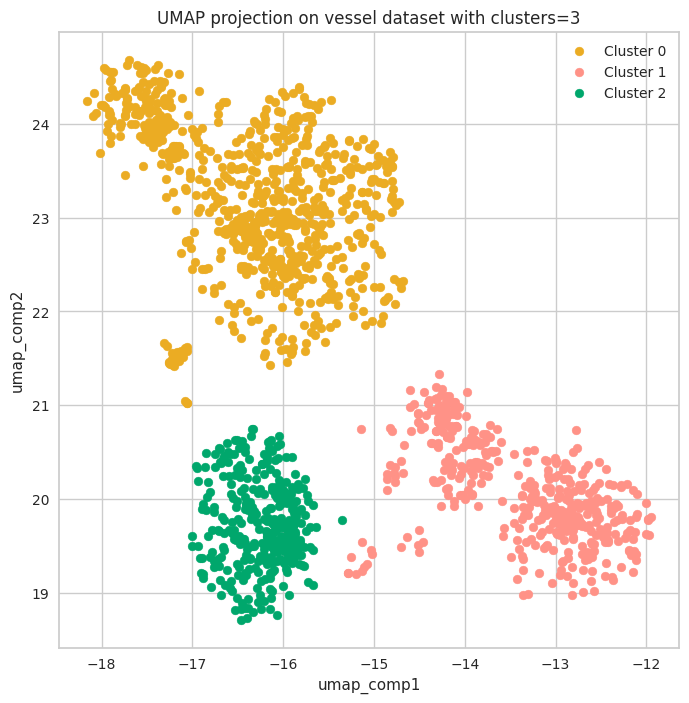

In [29]:
y_hc = plot_2d_agg_cluster(df_vessel[['comp1', 'comp2']].values, 3)

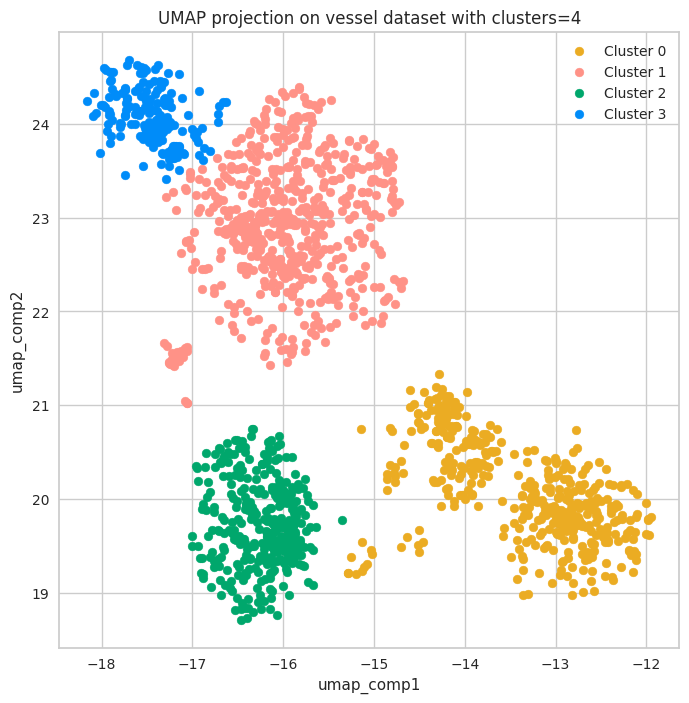

In [30]:
y_hc = plot_2d_agg_cluster(df_vessel[['comp1', 'comp2']].values, 4)

In [31]:
silhouette_score(df_vessel[['comp1','comp2']],y_hc)

0.5568365162459604

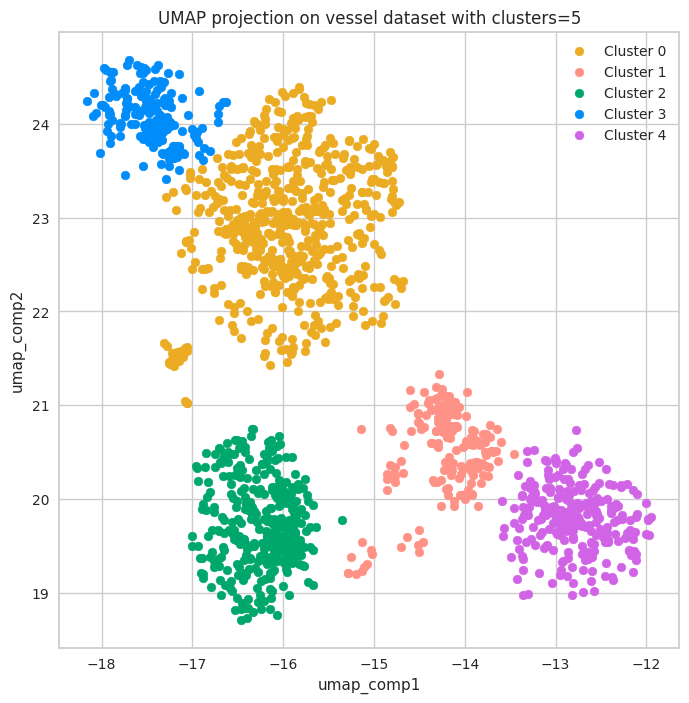

In [32]:
y_hc = plot_2d_agg_cluster(df_vessel[['comp1', 'comp2']].values, 5)

In [33]:
silhouette_score(df_vessel[['comp1','comp2']],y_hc)

0.5408902180737528

Findings:
- Agglomerative clustering did well on identifying clusters as Kmeans, and higher than the DBSCAN. with n_cluster = 5, the silhouette score of the Kmeans (0.543) and Agglomerative clustering (0.541) is almost the same, which are alo higher than that of the DBSCAN (0.499).
- All of them missed one terminal (Pier G)because of the small number of the records.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6b18b33d-3a56-4f49-ad6e-71ecea9f0183' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>